In [51]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
from neural_net import create_train_state, train, neural_ode

In [11]:
import importlib
import optimization_pyomo
import data_generation

importlib.reload(optimization_pyomo)
ODEOptimizationModel = optimization_pyomo.ODEOptimizationModel

In [12]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [5]:
tol_li = np.logspace(-4.0, -7.0, num=10)  
tol_li

array([1.00000000e-04, 4.64158883e-05, 2.15443469e-05, 1.00000000e-05,
       4.64158883e-06, 2.15443469e-06, 1.00000000e-06, 4.64158883e-07,
       2.15443469e-07, 1.00000000e-07])

In [38]:
layer_widths = [2, 10, 2]
results_tol = {}

tol_li = np.logspace(-4.0, -7.0, num=10)  
tol_li = [1e-6]

for tol in tol_li:
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, y_init = estimated_solution, penalty = True, penalty_lambda = 0, tol = tol, verbose= True, max_iter = 500, print_level= 5)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_tol[tol] = {
        "tol":tol, "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, "t" : t,
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']
        }

Ipopt 3.14.16: print_level=5
max_iter=500
tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    40639

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints...

In [39]:
u, v = ode_model.extract_solution()

In [40]:
results_tol.keys()

dict_keys([1e-08])

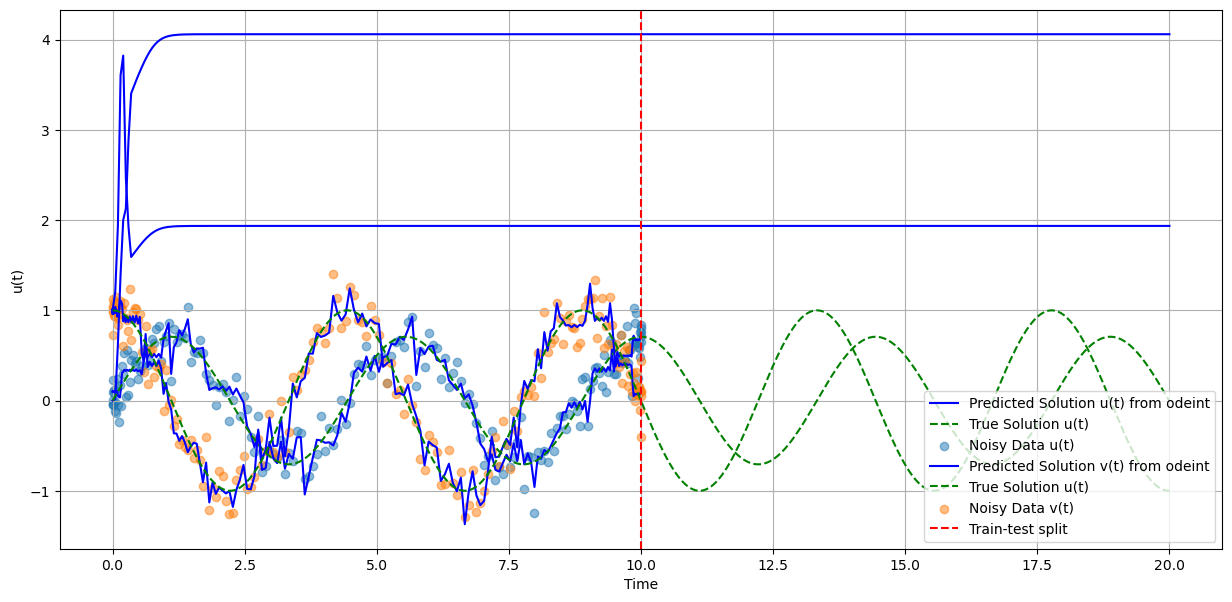

In [42]:
y_pred_test = results_tol[1e-08]['y_pred_test']

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, u, 'b')
plt.plot(t_test, y_pred_test.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

#plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, v, 'b')
plt.plot(t_test, y_pred_test.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [44]:
df_results = pd.DataFrame(results_tol).T

df_results['tol_scientific'] = df_results['tol'].apply(lambda x: f"{x:.2e}")
df_results = df_results.sort_values(by = 'tol', ascending = False)
df_results[['tol_scientific', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,tol_scientific,time_elapsed,mae_test,mae,termination_condition
1.000000e-08,1.00e-08,53.008392,3.009675089423438,2.6079458258467243,maxIterations


In [49]:
layer_widths = [2, 10, 2]

results_dual_inf_tol= {}
params_li = [{'dual_inf_tol':0.001},{'dual_inf_tol':0.01},{'dual_inf_tol':0.1},{'dual_inf_tol':1}, {'dual_inf_tol':10}, {'dual_inf_tol':100}]

for i, params in enumerate(params_li):
    #---------------------------------MODEL---------------------------------#
    ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, y_init = estimated_solution, max_iter = 1000, penalty = False, tol = 1e-5, verbose= True, print_level = 5, params = params)
    ode_model.build_model()
    result = ode_model.solve_model()
    
    #------------------------------ ODEINT PREP ----------------------------#
    def system_dynamics(y, t):
        u, v = y
        du_dt, dv_dt = ode_model.predict(u, v)
        return jnp.array([du_dt, dv_dt])
    
    initial_conditions = jnp.array([0.0, 1.0]) 
    #---------------------------MEAN ABSOLUTE ERROR--------------------------#

    y_pred_train = odeint(system_dynamics, initial_conditions, t)    
    mae_train = jnp.mean(jnp.abs(y_pred_train - y))
    
    y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
    mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))
    
    #------------------------------SAVING RESULTS----------------------------#

    results_dual_inf_tol[i] = {
        "dual_inf_tol": params['dual_inf_tol'], "y_pred_train": y_pred_train, "y_pred_test" : y_pred_test, 
        "t" : t,
        "u" : ode_model.extract_solution()[0], "v" : ode_model.extract_solution()[1],
        "time_elapsed": result['solver_time'], "mae_test" : mae_test, "mae":mae_train,
        "termination_condition": result['termination_condition'], "message": result['message']
        }

Ipopt 3.14.16: print_level=5
max_iter=1000
tol=1e-05
dual_inf_tol=0.001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    96316
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20619

Total number of variables............................:      452
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

In [50]:
df_dual_inf_tol = pd.DataFrame(results_dual_inf_tol).T
df_dual_inf_tol[['dual_inf_tol', 'time_elapsed', 'mae_test', 'mae', 'termination_condition']]

,dual_inf_tol,time_elapsed,mae_test,mae,termination_condition
0,0.001,71.055733,1.036561089607472,0.8723990163509591,maxIterations
1,0.01,73.32979,1.036561089607472,0.8723990163509591,maxIterations
2,0.1,80.114771,1.036561089607472,0.8723990163509591,maxIterations
3,1,81.790608,1.036561089607472,0.8723990163509591,maxIterations
4,10,80.484658,1.036561089607472,0.8723990163509591,maxIterations
5,100,83.418521,1.036561089607472,0.8723990163509591,maxIterations


In [61]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, Constraint, Objective, SolverFactory, value, RangeSet
import jax
import jax.numpy as jnp

In [83]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [84]:
class ODEOptimizationModel:
    def __init__(self, y_observed, t, first_derivative_matrix, layer_sizes, penalty_lambda=100, max_iter=500, act_func="tanh", w_init_method="random", y_init = None):
        self.y_observed = y_observed
        self.t = t
        self.first_derivative_matrix = first_derivative_matrix
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes
        self.model = ConcreteModel()
        self.y_init = y_init

    def initialize_weights(self, shape):
        if self.w_init_method == 'random':
            return np.random.randn(*shape) * 0.1
        elif self.w_init_method == 'xavier':
            return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, size):
        return np.random.randn(size) * 0.1

    def build_model(self):
        N = len(self.t)
        model = self.model
        model.t_idx = RangeSet(0, N - 1)

        if self.y_init == None:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
        else:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[0]))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[1]))

        if len(self.layer_sizes) == 3:
            input_size = self.layer_sizes[0]
            hidden_size = self.layer_sizes[1]
            output_size = self.layer_sizes[2]

            model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=0.1)
            model.b1 = pyo.Var(range(hidden_size), initialize=0.1)
            model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=0.1)
            model.b2 = pyo.Var(range(output_size), initialize=0.1)

        smoothing_terms = []
        
        model.ode = ConstraintList()
        for i in range(1, N):
            du_dt = sum(self.first_derivative_matrix[i, j] * model.u[j] for j in range(N))
            dv_dt = sum(self.first_derivative_matrix[i, j] * model.v[j] for j in range(N))

            nn_u, nn_v = self.nn_output(model.u[i], model.v[i], model)

            collocation_constraint_u = nn_u - du_dt
            collocation_constraint_v = nn_v - dv_dt

            model.ode.add(collocation_constraint_u == 0)
            model.ode.add(collocation_constraint_v == 0)
            
            if i < N - 1:
                smoothing_terms.append((model.u[i + 1] - model.u[i])**2 + (model.v[i + 1] - model.v[i])**2)

        def _objective(m):
            data_fit = sum((m.u[i] - self.y_observed[i, 0])**2 + (m.v[i] - self.y_observed[i, 1])**2 for i in m.t_idx)
            # penalty = self.penalty_lambda * sum(penalty_terms)
            return data_fit

        model.obj = Objective(rule=_objective, sense=pyo.minimize)
        self.model = model

    def nn_output(self, u, v, m):
        inputs = [u, v]
        if len(self.layer_sizes) == 3:
            W1, b1, W2, b2 = m.W1, m.b1, m.W2, m.b2
            hidden = [sum(W1[j, k] * inputs[k] for k in range(self.layer_sizes[0])) + b1[j] for j in range(self.layer_sizes[1])]
            if self.act_func == "tanh":
                hidden = [pyo.tanh(h) for h in hidden]
            elif self.act_func == "sigmoid":
                hidden = [1 / (1 + pyo.exp(-h)) for h in hidden]
            elif self.act_func == "softplus":
                hidden = [pyo.log(1 + pyo.exp(h)) for h in hidden]
            outputs = [sum(W2[j, k] * hidden[k] for k in range(self.layer_sizes[1])) + b2[j] for j in range(self.layer_sizes[2])]
            return outputs  # Ensure outputs are returned

    def solve_model(self):
        solver = pyo.SolverFactory('ipopt')
        # solver.options['max_iter'] = self.max_iter
        solver.options['print_level'] = 5
        solver.options['tol'] = 1e-3  # Set tolerance if needed
        # {'dual_inf_tol':10000}
        solver.options['dual_inf_tol'] = 1000
        # {'mu_strategy':'adaptive'}
        solver.options['mu_strategy'] = 'adaptive'
        
        # solver.options['mu_strategy'] = 'adaptive' # 'monotone'
        
        result = solver.solve(self.model, tee=True)
        
        # ------------------- Extract solver information -------------------
        solver_time = result.solver.time
        termination_condition = result.solver.termination_condition
        message = result.solver.message
        
        # ----------------- Extracted information in a dictionary ----------
        solver_info = {
            'solver_time': solver_time,
            'termination_condition': termination_condition,
            'message': message
        }
        
        return solver_info

    def extract_solution(self):
        u = np.array([pyo.value(self.model.u[i]) for i in self.model.t_idx])
        v = np.array([pyo.value(self.model.v[i]) for i in self.model.t_idx])
        return u, v

    def extract_weights(self):
        weights = {}
        if len(self.layer_sizes) == 3:
            W1 = np.array([[pyo.value(self.model.W1[j, k]) for k in range(self.layer_sizes[0])] for j in range(self.layer_sizes[1])])
            b1 = np.array([pyo.value(self.model.b1[j]) for j in range(self.layer_sizes[1])])
            W2 = np.array([[pyo.value(self.model.W2[j, k]) for k in range(self.layer_sizes[1])] for j in range(self.layer_sizes[2])])
            b2 = np.array([pyo.value(self.model.b2[j]) for j in range(self.layer_sizes[2])])
            weights['W1'], weights['b1'], weights['W2'], weights['b2'] = W1, b1, W2, b2
        return weights

    def predict(self, u, v):
        weights = self.extract_weights()
        inputs = jnp.array([u, v])

        if len(self.layer_sizes) == 3:
            W1, b1, W2, b2 = weights['W1'], weights['b1'], weights['W2'], weights['b2']
            hidden = jnp.tanh(jnp.dot(W1, inputs) + b1)
            outputs = jnp.dot(W2, hidden) + b2

        return outputs

    def mae(self, y_true, u, v):
        combined = np.vstack((u, v)).T
        mae_result = np.mean(np.abs(y_true - combined))
        return mae_result

if __name__ == "__main__":
    """ode_model = ODEOptimizationModel(y_observed, t, first_derivative_matrix)
    ode_model.build_model()
    ode_model.solve_model()
    u, v = ode_model.extract_solution()"""


In [85]:
layer_widths = [2, 20, 2]

start_timer_build = time.time()
ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, max_iter = 1000, y_init = estimated_solution)
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
mae_test = jnp.mean(jnp.abs(y_pred_test[200:] - y_test[200:]))

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(result)

Ipopt 3.14.16: print_level=5
tol=0.001
dual_inf_tol=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    40639

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constrain

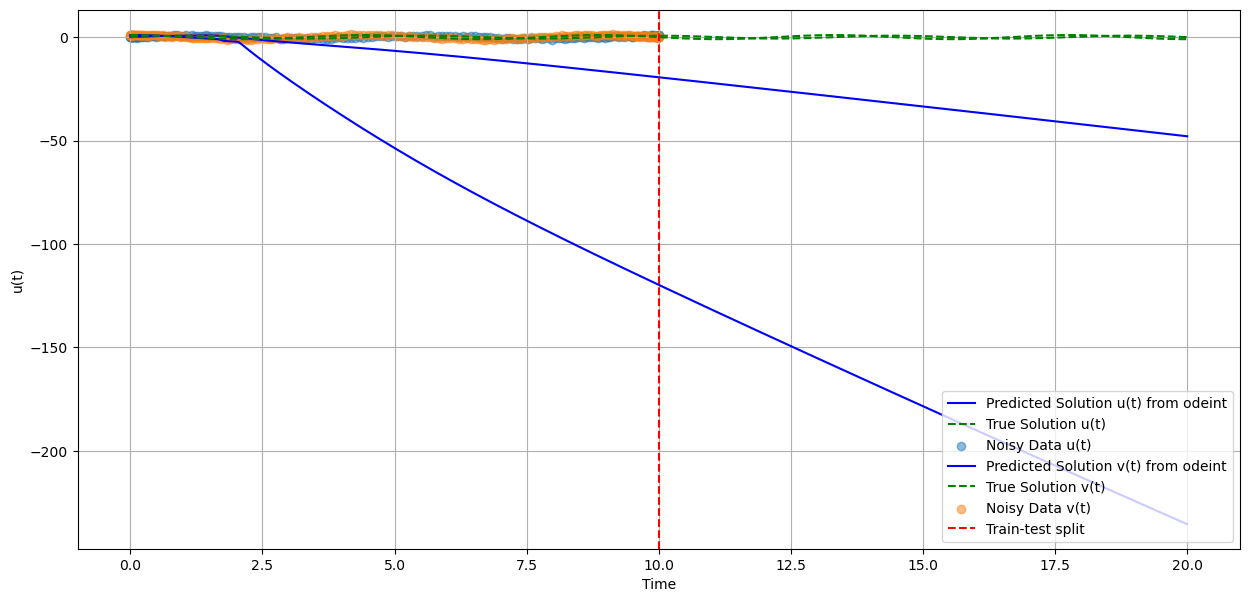

In [71]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, y_pred_test.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, y_pred_test.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()